## Preamble

In [1]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('mpg.csv')
print('Attribute Information:\n1. mpg: continuous \n2. cylinders: multi-valued discrete \n'
'3. displacement: continuous \n4. horsepower: continuous \n5. weight: continuous \n6. acceleration: continuous \n'
'7. model year: multi-valued discrete \n8. origin: multi-valued discrete \n9. car name: string (unique for each instance)\n')
df.head()

Attribute Information:
1. mpg: continuous 
2. cylinders: multi-valued discrete 
3. displacement: continuous 
4. horsepower: continuous 
5. weight: continuous 
6. acceleration: continuous 
7. model year: multi-valued discrete 
8. origin: multi-valued discrete 
9. car name: string (unique for each instance)



,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Check for null values:

We came to know that horsepower has 6 null values marked as '?', we will go ahead and drop those values

In [3]:
df = df[df['horsepower'] != '?']
df.reset_index()
df.horsepower = df.horsepower.astype('float') # horse power is an object type due to '?', convert into float after removal of '?'

df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

Describe the data

In [4]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


## Exploratory Data Analysis

Let's see the covariance heatmap!

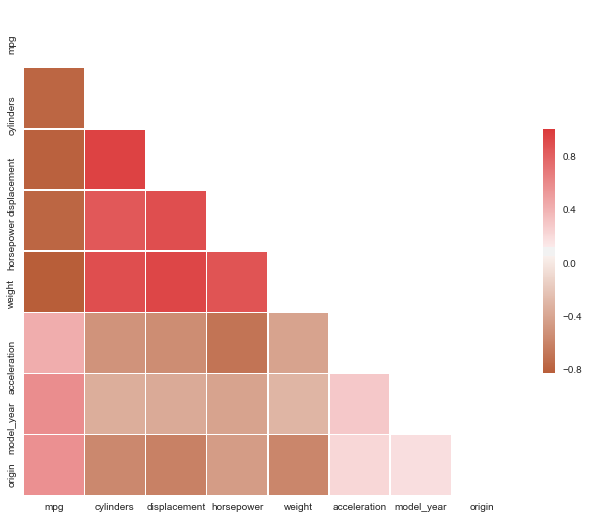

In [5]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(385, 12, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Weight, displacement and cylinders are inversly correlated (strong) to mpg whereas origin, model_year and accelration are weakly correlated. 

Converting the origin column from an integer to a descriptive categorical variable. By looking at the data and cross-referencing it with my knowledge of which brands are based in which countries, I can discern that the origins in this dataset are 

1 = United States ("USA") 

2 = Europe

3 = Japan

In [6]:
df['Country_code'] = df.origin.replace([1,2,3],['USA','Europe','Japan'])

df.groupby(['Country_code'], as_index=False).count()[['Country_code', 'origin']]

,Country_code,origin
0,Europe,68
1,Japan,79
2,USA,245


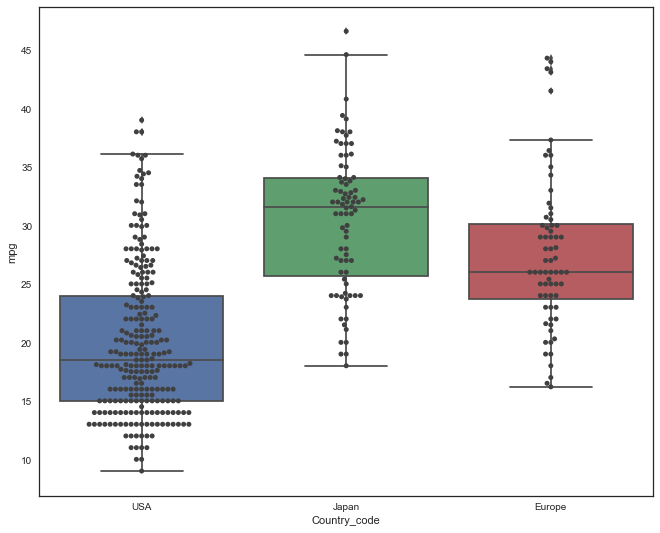

In [7]:

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax = sns.boxplot(x="Country_code", y="mpg", data = df)
ax = sns.swarmplot(x="Country_code", y="mpg", data = df, color=".25")

Wow! there's a big difference in mpg from different countries.

Let's see how it changed over the years!

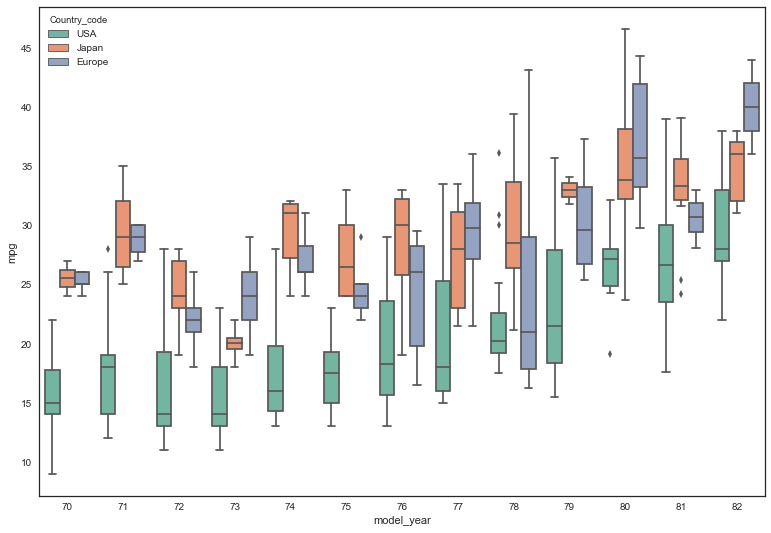

In [8]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 9))

ax = sns.boxplot(x = 'model_year', y = 'mpg', hue = 'Country_code', data = df, palette="Set2")

Japan was killing it until 1979 but then Europ and USA started to take over.

USA has been increasing gradually from the begining.

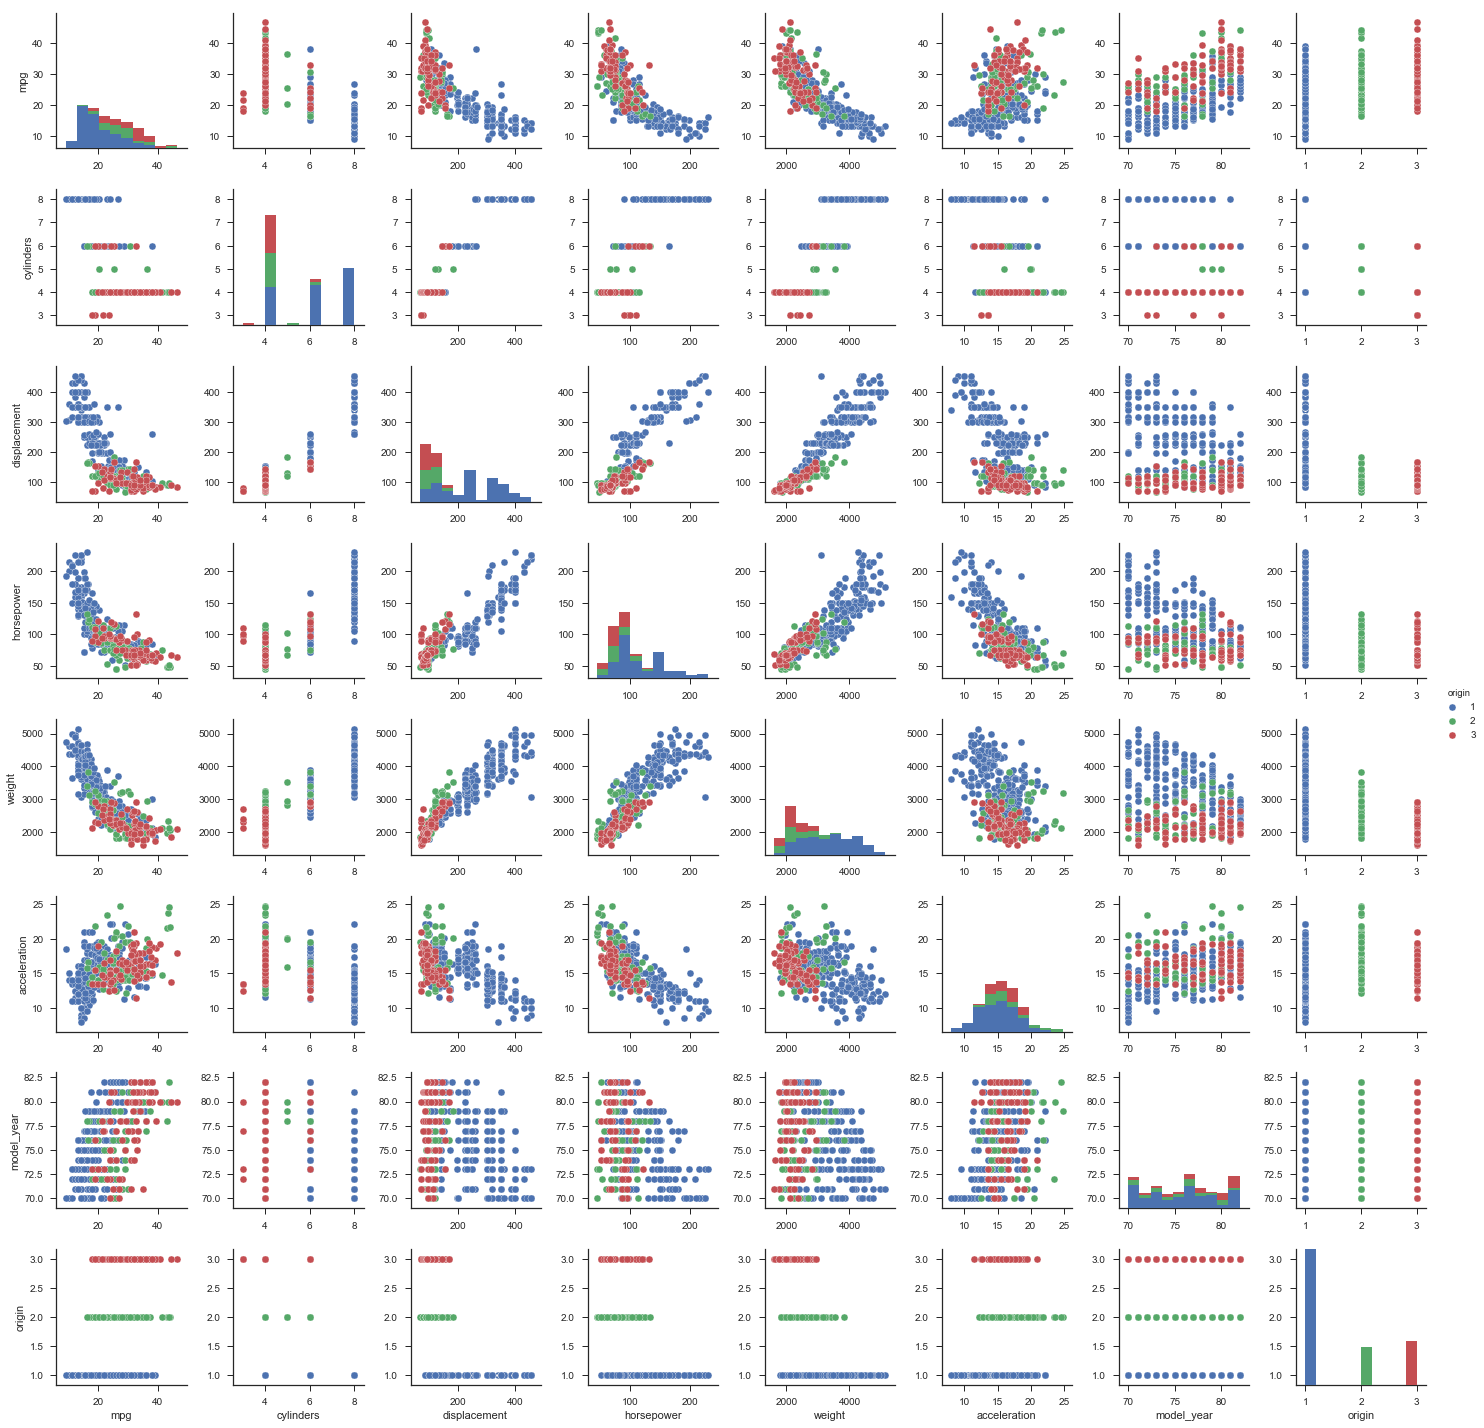

In [9]:
# Let's see how all the attributes interact with each other
sns.set(style="ticks", color_codes=True)

g = sns.pairplot(df, hue = 'origin')

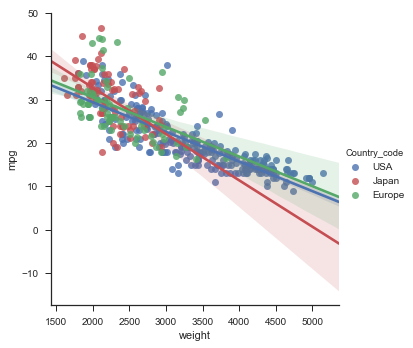

In [10]:
sns.lmplot(x = 'weight', y = 'mpg', hue = 'Country_code', data = df, palette=dict(USA = "b", Japan = "r", Europe = 'g'))

- Weight, horsepower and displacement have logorithmic relationhip with mpg
- Acceleration and displacement have an inverse interaction, maybe test an interaction variable in the model?
- Cylinders won't make much difference country wise
- model year has increase trend, will will treat it numerically as it represent technological and policy reformations over the years

**Based on our exploratory data analysis, we will create transformed variables, add interaction variable and regresss the data 3 times: one regression for each country**

## Data Preparation

Attributes transformation and interaction variable:

In [11]:
# Log transforation
df['log_weight'] = np.log(df.weight)
df['log_displacement'] = np.log(df.displacement)
df['log_horsepower'] = np.log(df.horsepower)

In [12]:
# Interaction variable of acceleration and displacement
# Taking log as it has logrithmic relationship with mpg
df['axd'] = np.log(df['acceleration'] * df['displacement'])
d = df

Scaling the attributes

In [13]:
## Scaling using MinMax Scaler
scaler = MinMaxScaler()                          #for scaling

# first let's take only the attributes meaningful to us
# Some might argue why we did not include model year from the regression, model year represents technological advancements
# which is already covered in other attributes, hence model_year is not included

# Data for USA
df_X_USA = df[(df['Country_code'] == 'USA') | (df['Country_code'] == 'Europe')][['log_horsepower', 'acceleration', 'log_weight', 'log_displacement', 'axd', 'model_year']]
scaler.fit(df_X_USA)                                   
df_X_USA =np.array(scaler.transform(df_X_USA))

df_y_USA = df[(df['Country_code'] == 'USA') | (df['Country_code'] == 'Europe')][['mpg']]
scaler.fit(df_y_USA)                                   
df_y_USA =np.array(scaler.transform(df_y_USA))

# Data for Rest
df_X = df[(df['Country_code'] == 'Europe') | (df['Country_code'] == 'Japan')][['log_horsepower', 'acceleration', 'log_weight', 'log_displacement', 'axd', 'model_year']]
scaler.fit(df_X)                                   
df_X =np.array(scaler.transform(df_X))

df_y = df[(df['Country_code'] == 'Europe') | (df['Country_code'] == 'Japan')][['mpg']]
scaler.fit(df_y)                                   
df_y =np.array(scaler.transform(df_y))

## Regression
- Split data
- Run regression for each country (origin)
- Plot Residuals

In [14]:
## Create an instance of a LinearRegression() model named lm
lm = LinearRegression()

### United States of America
**Split the train and test data**

In [15]:
# 70-30 split for USA since it has more data points
X_train, X_test, y_train, y_test = train_test_split(df_X_USA, df_y_USA, test_size=0.3, random_state=301)

**Train Regression**

In [16]:
lm_USA = lm.fit(X_train,y_train)

# The coefficients
print('Coefficients: \n', lm_USA.coef_)
print('\nTraining score: ', round(lm_USA.score(X_train, y_train), 2))
print('Training MSE: ', round(metrics.mean_squared_error(y_train, lm_USA.predict( X_train)), 2))
print('\nTesting score: ', round(lm_USA.score(X_test, y_test), 2))
print('Testing MSE: ', round(metrics.mean_squared_error(y_test, lm_USA.predict( X_test)), 2))


Coefficients: 
 [[-0.27117424  0.77067568 -0.32141851  1.46808361 -1.48926545  0.21727614]]

Training score:  0.85
Training MSE:  0.01

Testing score:  0.85
Testing MSE:  0.01


We have, both, testing and training score as 85% which is satisfactory.

**Residuals plot**

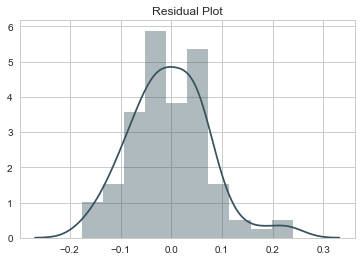

In [17]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

plt.title('Residual Plot')
sns.distplot((y_test-lm_USA.predict( X_test)))

### Rest of the World (Europe and Japan)
**Split the train and test data**

In [18]:
# 70-30 for EU since it has only 79 data points
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=344)

**Train Regression**

In [19]:
lm_EU = lm.fit(X_train,y_train)

# The coefficients
print('Coefficients: \n', lm_EU.coef_)
print('\nTraining score: ', round(lm_EU.score(X_train, y_train), 2))
print('Training MSE: ', round(metrics.mean_squared_error(y_train, lm_EU.predict( X_train)), 2))
print('\nTesting score: ', round(lm_EU.score(X_test, y_test), 2))
print('Testing MSE: ', round(metrics.mean_squared_error(y_test, lm_EU.predict( X_test)), 2))


Coefficients: 
 [[-0.04183447  0.72890168 -0.63224873  0.72663914 -0.90059605  0.36958215]]

Training score:  0.66
Training MSE:  0.01

Testing score:  0.77
Testing MSE:  0.01


We have a low training score of 66% whereas a descent score of 77% for testing dataset.

These results show high variance due to lower sample size. If we increase data points for rest of the world, we will get even better results. Nevertheless, 77% score for a cross-setional data seems decent.

**Residuals plot**

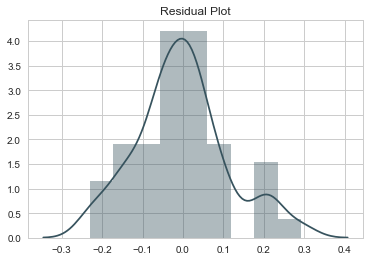

In [20]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

plt.title('Residual Plot')

sns.distplot((y_test-lm_EU.predict( X_test)))

That's a good result for a linear regression.

This was acheieved using:
- Log transformation
- Introduction of interaction variable

These models can further be improved using a bigger dataset.